In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.notebook import tqdm  # Use notebook version of tqdm for cleaner output in Jupyter/Colab
import random
from collections import deque
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.preprocessing import MinMaxScaler
import scipy.optimize as opt
from matplotlib.ticker import MaxNLocator
import math
from sklearn.decomposition import PCA
import akshare as ak

In [44]:
def obtain_CN_data(ticker, start_date, end_date):
    #start and end should be like this form:20220101
    stock_zh_a_hist_df = ak.stock_zh_a_hist(ticker, "daily", start_date, end_date, adjust="qfq")
    # Retain only the first 6 columns
    data = stock_zh_a_hist_df .iloc[:, :6]
    data['日期'] = pd.to_datetime(data['日期'])
    # Rename the columns
    column_mapping = {
        "日期": "Date",
        "开盘": "Open",
        "收盘": "Close",
        "最高": "High",
        "最低": "Low",
        "成交量": "Volume"
    }
    data = data.rename(columns=column_mapping)

    # Set the "Date" column as the index
    data = data.set_index('Date')
    return data

In [21]:
def obtian_Other_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return stock_data

In [54]:
def fetch_stock_data(ticker, start_date, end_date):
    
    stock_data = obtian_Other_data(ticker, start_date, end_date)
    #stock_data=obtain_CN_data(ticker, start_date, end_date)
    
    High=stock_data['High']
    Low=stock_data['Low']
    Open=stock_data['Open']
    Close=stock_data['Close']
    Volume=stock_data['Volume']
    
    #累积/派发线（Accumulation / Distribution Line，该指标将每日的成交量通过价格加权累计，
    #用以计算成交量的动量。属于趋势型因子
    stock_data['AD'] = talib.AD(High, Low, Close, Volume)
    # 佳庆指标（Chaikin Oscillator），该指标基于AD曲线的指数移动均线而计算得到。属于趋势型因子
    stock_data['ADOSC'] = talib.ADOSC(High, Low, Close, Volume, fastperiod=3, slowperiod=10)
    # 平均动向指数，DMI因子的构成部分。属于趋势型因子
    stock_data['ADX'] = talib.ADX(High, Low, Close,timeperiod=14)
    # 相对平均动向指数，DMI因子的构成部分。属于趋势型因子
    stock_data['ADXR'] = talib.ADXR(High, Low, Close,timeperiod=14)
    # 绝对价格振荡指数
    stock_data['APO'] = talib.APO(Close, fastperiod=12, slowperiod=26)
    # Aroon通过计算自价格达到近期最高值和最低值以来所经过的期间数，帮助投资者预测证券价格从趋势到区域区域或反转的变化，
    #Aroon指标分为Aroon、AroonUp和AroonDown3个具体指标。属于趋势型因子
    stock_data['AROONDown'], stock_data['AROONUp'] = talib.AROON(High, Low,timeperiod=14)
    stock_data['AROONOSC'] = talib.AROONOSC(High, Low,timeperiod=14)
    
    # 均幅指标（Average TRUE Ranger），取一定时间周期内的股价波动幅度的移动平均值，
    #是显示市场变化率的指标，主要用于研判买卖时机。属于超买超卖型因子。
    stock_data['ATR14']= talib.ATR(High, Low, Close, timeperiod=14)
    stock_data['ATR6']= talib.ATR(High, Low, Close, timeperiod=6)
    
    # 布林带
    stock_data['Boll_Up'],stock_data['Boll_Mid'],stock_data['Boll_Down']= talib.BBANDS(Close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
     # 均势指标
    stock_data['BOP'] = talib.BOP(Open, High, Low, Close)
    #5日顺势指标（Commodity Channel Index），专门测量股价是否已超出常态分布范围。属于超买超卖型因子。
    stock_data['CCI5'] = talib.CCI(High, Low, Close, timeperiod=5)
    stock_data['CCI10'] = talib.CCI(High, Low, Close, timeperiod=10)
    stock_data['CCI20'] = talib.CCI(High, Low, Close, timeperiod=20)
    stock_data['CCI88'] = talib.CCI(High, Low, Close, timeperiod=88)
    # 钱德动量摆动指标（Chande Momentum Osciliator），与其他动量指标摆动指标如相对强弱指标（RSI）和随机指标（KDJ）不同，
    # 钱德动量指标在计算公式的分子中采用上涨日和下跌日的数据。属于超买超卖型因子
    stock_data['CMO_Close'] = talib.CMO(Close,timeperiod=14)
    stock_data['CMO_Open'] = talib.CMO(Close,timeperiod=14)
    # DEMA双指数移动平均线
    stock_data['DEMA6'] = talib.DEMA(Close, timeperiod=6)
    stock_data['DEMA12'] = talib.DEMA(Close, timeperiod=12)
    stock_data['DEMA26'] = talib.DEMA(Close, timeperiod=26)
     # DX 动向指数
    stock_data['DX'] = talib.DX(High, Low, Close,timeperiod=14)

    # EMA 指数移动平均线
    stock_data['EMA6'] = talib.EMA(Close, timeperiod=6)
    stock_data['EMA12'] = talib.EMA(Close, timeperiod=12)
    stock_data['EMA26'] = talib.EMA(Close, timeperiod=26)

    # KAMA 适应性移动平均线
    stock_data['KAMA'] = talib.KAMA(Close, timeperiod=30)

    # MACD
    stock_data['MACD_DIF'],stock_data['MACD_DEA'],stock_data['MACD_bar'] = talib.MACD(Close, fastperiod=12, slowperiod=24, signalperiod=9)

    # 中位数价格 不知道是什么意思
    stock_data['MEDPRICE'] = talib.MEDPRICE(High, Low)

    # 负向指标 负向运动
    stock_data['MiNUS_DI'] = talib.MINUS_DI(High, Low, Close,timeperiod=14)
    stock_data['MiNUS_DM'] = talib.MINUS_DM(High, Low,timeperiod=14)

    # 动量指标（Momentom Index），动量指数以分析股价波动的速度为目的，研究股价在波动过程中各种加速，
    #减速，惯性作用以及股价由静到动或由动转静的现象。属于趋势型因子
    stock_data['MOM'] = talib.MOM(Close, timeperiod=10)

    # 归一化平均值范围
    stock_data['NATR'] = talib.NATR(High, Low, Close,timeperiod=14)

    # OBV 	能量潮指标（On Balance Volume，OBV），以股市的成交量变化来衡量股市的推动力，
    #从而研判股价的走势。属于成交量型因子
    stock_data['OBV'] = talib.OBV(Close, Volume)

    # PLUS_DI 更向指示器
    stock_data['PLUS_DI'] = talib.PLUS_DI(High, Low, Close,timeperiod=14)
    stock_data['PLUS_DM'] = talib.PLUS_DM(High, Low, timeperiod=14)

    # PPO 价格振荡百分比
    stock_data['PPO'] = talib.PPO(Close, fastperiod=6, slowperiod= 26, matype=0)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    #通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    stock_data['ROC6'] = talib.ROC(Close, timeperiod=6)
    stock_data['ROC20'] = talib.ROC(Close, timeperiod=20)
    #12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    #通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    #达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    #属于成交量的反趋向指标。属于成交量型因子
    stock_data['VROC6'] = talib.ROC(Volume, timeperiod=6)
    stock_data['VROC20'] = talib.ROC(Volume, timeperiod=20)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    #通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    stock_data['ROCP6'] = talib.ROCP(Close, timeperiod=6)
    stock_data['ROCP20'] = talib.ROCP(Close, timeperiod=20)
    #12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    #通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    #达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    #属于成交量的反趋向指标。属于成交量型因子
    stock_data['VROCP6'] = talib.ROCP(Volume, timeperiod=6)
    stock_data['VROCP20'] = talib.ROCP(Volume, timeperiod=20)
    # RSI
    stock_data['RSI'] = talib.RSI(Close, timeperiod=14)
    # SAR 抛物线转向
    stock_data['SAR'] = talib.SAR(High, Low, acceleration=0.02, maximum=0.2)
    # TEMA
    stock_data['TEMA6'] = talib.TEMA(Close, timeperiod=6)
    stock_data['TEMA12'] = talib.TEMA(Close, timeperiod=12)
    stock_data['TEMA26'] = talib.TEMA(Close, timeperiod=26)
    # TRANGE 真实范围
    stock_data['TRANGE'] = talib.TRANGE(High, Low, Close)
    # TYPPRICE 典型价格
    stock_data['TYPPRICE'] = talib.TYPPRICE(High, Low, Close)
    # TSF 时间序列预测
    stock_data['TSF'] = talib.TSF(Close, timeperiod=14)
    # ULTOSC 极限振子
    stock_data['ULTOSC'] = talib.ULTOSC(High, Low, Close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    # 威廉指标
    stock_data['WILLR'] = talib.WILLR(High, Low, Close, timeperiod=14)
    
    
    
    # Drop any NaN values
    stock_data.dropna(inplace=True)
    # Extract the unscaled columns
    unscaled_data = stock_data[['High','Low','Adj Close','Close','Open']]
    #unscaled_data = stock_data[['High','Low','Close','Open']]
    # Extract the columns to be scaled
    features=stock_data.columns.tolist()[5:]
    features_to_scale = stock_data[features]

    # Scale the features
    scaler = MinMaxScaler()
    scaled_features = pd.DataFrame(scaler.fit_transform(features_to_scale), columns=features_to_scale.columns, index=stock_data.index)

    # Concatenate the unscaled and scaled data
    final_data = pd.concat([unscaled_data, scaled_features], axis=1)
    
    # Return only final_data
    return final_data
    #return stock_data

In [55]:
def apply_pca(data, n_components=5):
    # Extract the columns to be used for PCA
    features = data.columns.tolist()[5:]
    features_to_pca = data[features]

    # Apply PCA with the specified number of components
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(features_to_pca)

    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # Create a DataFrame to store the principal components
    principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components + 1)], index=data.index)

    # Concatenate the principal components with the non-feature columns
    data_non_feature = data.iloc[:, :5]  # Assuming the non-feature columns are the first 5 columns
    data_with_pca = pd.concat([data_non_feature, principal_df], axis=1)

    return data_with_pca, explained_variance_ratio

# Example usage:
# stock_data_with_pca, explained_variance = apply_pca(stock_data, n_components=5)


In [56]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, action_size)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = self.dropout3(torch.relu(self.fc3(x)))
        return self.fc4(x)



In [57]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000) 
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.998
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)  # Decrease LR every 100 episodes by a factor of 0.9

    def _build_model(self):
        model = DQN(self.state_size, self.action_size)
        return model
    def update_target_model(self):
        """Update the target model weights with the main model weights."""
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = torch.FloatTensor(state)
        if np.random.rand() <= self.epsilon:  # Exploration
            return random.randrange(self.action_size)
        with torch.no_grad():
            act_values = self.model(state)  # Exploitation
        return torch.argmax(act_values[0]).item()
    
    def compute_sharpe_ratio(self, portfolio_values):
        if len(portfolio_values) < 2:
            return 0

        daily_returns = [portfolio_values[i] / portfolio_values[i - 1] - 1 for i in range(1, len(portfolio_values))]
        avg_return = np.mean(daily_returns)
        std_return = np.std(daily_returns)

        if std_return == 0:
            return 0

        return avg_return / std_return
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            reward = torch.FloatTensor([reward])
            action = torch.LongTensor([action])

            # Corrected target calculation
            with torch.no_grad():
                next_state_values = self.target_model(next_state)
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(next_state_values)

            current = self.model(state)[0][action]
            loss = self.criterion(current, target)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


    def save_best(self, name):
        """Save the model weights."""
        torch.save(self.model.state_dict(), name)
    
    def load_best(self, name):
        """Load the model weights."""
        self.model.load_state_dict(torch.load(name))

In [58]:
def train_dqn(episodes, stock_data, validation_data, agent, save_path="best_model.pth"):
    state_size = stock_data.shape[1]
    batch_size = 32
    episode_rewards = []
    best_validation_performance = float('-inf')  # Initialize with a very low value
    
    for e in tqdm(range(episodes), desc="Training"):
        
        state = stock_data.iloc[0].values
        state = np.reshape(state, [1, state_size])
        total_reward = 0
        
        initial_investment = 100000
        cash = initial_investment
        transaction_cost_rate = 0
        stamp_duty_rate = 0
        total_shares = 0
        portfolio_values = [initial_investment]
        
        for t in range(len(stock_data) - 1):
            action = agent.act(state)
            next_state = stock_data.iloc[t + 1].values
            next_state = np.reshape(next_state, [1, state_size])
            price = stock_data['Close'][t]
            
            price_movement = stock_data['Close'][t+1] - stock_data['Close'][t]

            if action == 1:  # Buy one
                shares_to_buy = 100
                transaction_cost = shares_to_buy * price * transaction_cost_rate
                stamp_duty = shares_to_buy * price * stamp_duty_rate
                total_cost = shares_to_buy * price + transaction_cost + stamp_duty
                if cash >= total_cost:
                    total_shares += shares_to_buy
                    cash -= total_cost

            elif action == 2:  # Double Buy
                shares_to_buy = 200
                transaction_cost = shares_to_buy * price * transaction_cost_rate
                stamp_duty = shares_to_buy * price * stamp_duty_rate
                total_cost = shares_to_buy * price + transaction_cost + stamp_duty
                if cash >= total_cost:
                    total_shares += shares_to_buy
                    cash -= total_cost

            elif action == 3:  # Sell one
                share_sell = 100
                transaction_cost = share_sell * price * transaction_cost_rate
                if total_shares >= 100:
                    cash += share_sell * price - transaction_cost
                    total_shares -= share_sell

            elif action == 4:  # Double Sell
                share_sell = 200
                transaction_cost = share_sell * price * transaction_cost_rate
                if total_shares >= 100:  # Not allow Short Sell
                    cash += share_sell * price - transaction_cost
                    total_shares -= share_sell
            # else:  # Hold action, no change

            portfolio_values.append(cash + total_shares * price)
            
            reward = (portfolio_values[-1] - portfolio_values[-2]) / portfolio_values[-2]
            total_reward += reward
            done = t == len(stock_data) - 2
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
                
        episode_rewards.append(total_reward)

        # Periodically evaluate on validation set
        if e % 10 == 0:  # Evaluate every 10 episodes, but you can adjust this frequency
            validation_performance = evaluate_on_validation_set(agent, validation_data)
            if validation_performance > best_validation_performance:
                best_validation_performance = validation_performance
                agent.save_best(save_path)

    # Plotting the rewards
    plt.plot(np.arange(episodes), episode_rewards, label='Rewards per episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards per Episode during Training')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.show()

    return agent


In [59]:
def evaluate_on_validation_set(agent, validation_data):
    # Initialization
    initial_investment = 100000
    cash = initial_investment
    transaction_cost_rate = 0
    stamp_duty_rate = 0
    state_size = validation_data.shape[1]
    validation_data_timestamps = validation_data.index[:-1]
    total_shares = 0
    portfolio_values = []

    for t in range(len(validation_data_timestamps)):
        current_state = validation_data.iloc[t].values
        current_state = np.reshape(current_state, [1, state_size])
        current_state_tensor = torch.FloatTensor(current_state)
        action = agent.act(current_state_tensor)
        price = validation_data['Close'].iloc[t]
        
        if action == 1:  # Buy
            shares_to_buy = 100
            transaction_cost = shares_to_buy * price * transaction_cost_rate
            stamp_duty = shares_to_buy * price * stamp_duty_rate
            total_cost = shares_to_buy * price + transaction_cost + stamp_duty
            if cash >= total_cost:
                total_shares += shares_to_buy
                cash -= total_cost
        elif action==2:
            shares_to_buy = 200
            transaction_cost = shares_to_buy * price * transaction_cost_rate
            stamp_duty = shares_to_buy * price * stamp_duty_rate
            total_cost = shares_to_buy * price + transaction_cost + stamp_duty
            if cash >= total_cost:
                total_shares += shares_to_buy
                cash -= total_cost

        elif action ==3:
            share_sell=100
            transaction_cost = share_sell * price * transaction_cost_rate
            if total_shares>=100:
                cash += share_sell * price - transaction_cost
                total_shares -= share_sell

        elif action == 4 :  # Sell
            share_sell=200
            transaction_cost = share_sell * price * transaction_cost_rate
            if total_shares>=200:
                cash += share_sell * price - transaction_cost
                total_shares -= share_sell

        portfolio_value = cash + total_shares * price
        portfolio_values.append(portfolio_value)

    # Performance Metrics
    total_return_percentage = ((portfolio_values[-1] - initial_investment) / initial_investment) * 100
    
    return total_return_percentage


In [60]:
def backtest(agent, data, initial_investment=100000, transaction_cost_rate=0, stamp_duty_rate=0):
    cash = initial_investment
    state_size = data.shape[1]
    data_timestamps = data.index[:-1]
    total_shares = 0
    portfolio_values = []

    # For visualization
    buy_points = []
    sell_points = []

    for t in tqdm(range(len(data_timestamps)), desc="Backtesting"):
        current_state = data.iloc[t].values
        current_state = np.reshape(current_state, [1, state_size])
        current_state_tensor = torch.FloatTensor(current_state)
        action = agent.act(current_state_tensor)
        price = data['Close'].iloc[t]
        
        if action == 1:  # Buy
            shares_to_buy = 100
            transaction_cost = shares_to_buy * price * transaction_cost_rate
            stamp_duty = shares_to_buy * price * stamp_duty_rate
            total_cost = shares_to_buy * price + transaction_cost + stamp_duty
            if cash >= total_cost:
                buy_points.append(t)
                total_shares += shares_to_buy
                cash -= total_cost
        elif action==2:
            shares_to_buy = 200
            transaction_cost = shares_to_buy * price * transaction_cost_rate
            stamp_duty = shares_to_buy * price * stamp_duty_rate
            total_cost = shares_to_buy * price + transaction_cost + stamp_duty
            if cash >= total_cost:
                buy_points.append(t)
                total_shares += shares_to_buy
                cash -= total_cost

        elif action ==3:
            share_sell=100
            transaction_cost = share_sell * price * transaction_cost_rate
            if total_shares>=100:
                sell_points.append(t)
                cash += share_sell * price - transaction_cost
                total_shares -= share_sell

        elif action == 4 :  # Sell
            share_sell=200
            transaction_cost = share_sell * price * transaction_cost_rate
            if total_shares>=200:
                sell_points.append(t)
                cash += share_sell * price - transaction_cost
                total_shares -= share_sell

        portfolio_value = cash + total_shares * price
        portfolio_values.append(portfolio_value)

    # Performance Metrics
    total_return_percentage = ((portfolio_values[-1] - initial_investment) / initial_investment) * 100
    print("Total Return: {:.2f}%".format(total_return_percentage))

    # Visualization
    plt.figure(figsize=(10,6))
    plt.plot(data_timestamps, portfolio_values, label='Portfolio Value')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.legend()
    plt.show()

    # New plot for Stock Price with Buy and Sell points
    plt.figure(figsize=(10,6))
    plt.plot(data_timestamps, data['Close'].iloc[:-1], label='Stock Price', alpha=0.7)
    plt.scatter(data_timestamps[buy_points], data['Close'].iloc[buy_points], marker='^', color='g', label='Buy Points', alpha=1)
    plt.scatter(data_timestamps[sell_points], data['Close'].iloc[sell_points], marker='v', color='r', label='Sell Points', alpha=1)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Stock Price with Buy and Sell Points Over Time')
    plt.legend()
    plt.show()

    return total_return_percentage, portfolio_values, buy_points, sell_points


In [61]:
def backtest_performance_summary(portfolio_values, buy_points, sell_points):
    # Convert portfolio_values to numpy array
    portfolio_values = np.array(portfolio_values)
    returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]

    # Metrics Calculations
    total_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]
    annualized_return = (1 + total_return)**(252 / len(portfolio_values)) - 1
    volatility = np.std(returns) * np.sqrt(252)
    max_drawdown = np.min(portfolio_values / np.maximum.accumulate(portfolio_values)) - 1
    
    # Cumulative Return
    cum_return = portfolio_values[-1] / portfolio_values[0] - 1
    
    # Sharpe and Sortino Ratios
    sharpe_ratio = annualized_return / volatility
    downside_std_dev = np.std(np.minimum(returns, 0)) * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std_dev if downside_std_dev != 0 else np.inf
    
    # Omega Ratio
    mar = 0  # Minimum Acceptable Return
    omega_ratio = np.mean(np.maximum(returns - mar, 0)) / np.mean(np.minimum(returns - mar, 0))

    # VaR, CVaR & ES
    alpha = 0.05  # Significance level
    var = -np.percentile(returns, alpha * 100)
    cvar = -np.mean(sorted(returns)[:int(alpha * len(returns))])
    es = cvar  # ES is equivalent to CVaR

    # RoMaD & ROT
    romad = annualized_return / abs(max_drawdown)
    rot = total_return / abs(max_drawdown)
    
    # Turnover Rate
    total_transactions = len(buy_points) + len(sell_points)
    average_portfolio_value = np.mean(portfolio_values)
    turnover_rate = total_transactions / average_portfolio_value
    
    
    # DataFrame for Performance Summary with rounding at the end
    performance_summary = pd.DataFrame({
        'Metric': ['Total Return (%)', 'Annualized Return (%)', 'Cumulative Return (%)','Volatility (%)', 'Max Drawdown (%)', 
                   'Sharpe Ratio', 'Sortino Ratio', 'VaR (95%)', 'cVaR (95%)', 'ES (95%)', 'Omega Ratio', 
                   'RoMaD', 'Turnover Rate', 'RoT'],
        'Value': [
            round(total_return * 100, 2),
            round(annualized_return * 100, 2),
            round(cum_return * 100, 2),
            round(volatility * 100, 2),
            round(max_drawdown * 100, 2),
            round(sharpe_ratio, 2),
            round(sortino_ratio, 2),
            round(var * 100, 2),
            round(cvar * 100, 2),
            round(es * 100, 2),
            round(omega_ratio, 2),
            round(romad, 2),
            round(turnover_rate, 4),
            round(rot, 2)
        ]
    })

    return performance_summary

In [62]:
# 1. Obtain Data
#stock_data = fetch_stock_data("600519", "20180101", "20231001")
stock_data = fetch_stock_data("AMZN", "2018-01-01", "2023-10-01")
stock_data_PCA,explained_variance = apply_pca(stock_data, n_components=10)

# Print the sum of explained variance
total_explained_variance = explained_variance.sum()
print(f"Total Explained Variance: {total_explained_variance * 100:.2f}%")

split_date_train_val = '2022-01-01'
split_date_val_test = '2023-01-01'

train_data = stock_data_PCA.loc[stock_data.index < split_date_train_val]
validation_data = stock_data_PCA.loc[(stock_data.index >= split_date_train_val) & (stock_data.index < split_date_val_test)]
test_data = stock_data_PCA.loc[stock_data.index >= split_date_val_test]

Total Explained Variance: 95.15%


In [63]:
# 2. Initialize the Agent
state_size = train_data.shape[1]
action_size = 5  # Assuming you have 5 actions: Hold, Buy 1, Buy 2, Sell 1, Sell 2
agent = DQNAgent(state_size, action_size)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

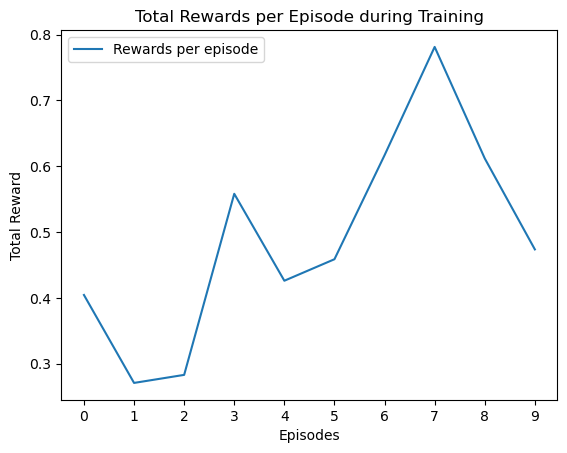

In [64]:
# 3. Training
episodes = 10  # You can adjust this number based on your needs
trained_agent = train_dqn(episodes, train_data, validation_data, agent)

Backtesting:   0%|          | 0/186 [00:00<?, ?it/s]

Total Return: 26.21%


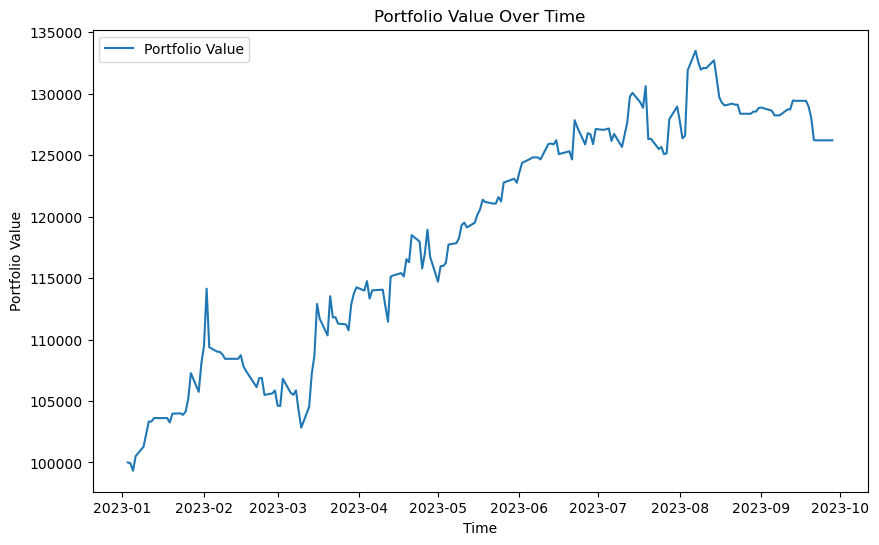

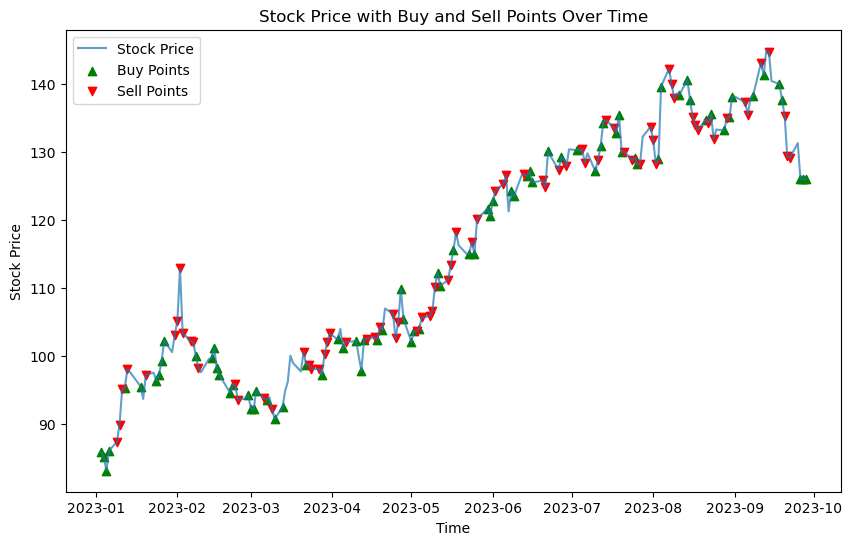

In [65]:
# 4. Backtesting
total_return_percentage, portfolio_values, buy_points, sell_points = backtest(trained_agent, test_data)

In [201]:
backtest_performance_summary(portfolio_values, buy_points, sell_points)

,Metric,Value
0,Total Return (%),25.940
1,Annualized Return (%),36.680
2,Cumulative Return (%),25.940
3,Volatility (%),19.310
4,Max Drawdown (%),-8.960
5,Sharpe Ratio,1.900
6,Sortino Ratio,3.200
7,VaR (95%),1.660
8,cVaR (95%),2.990
9,ES (95%),2.990
